<a href="https://colab.research.google.com/github/vaishnavi-kedar/demo1/blob/main/DeepLearning_LabAssignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Course Name**: Deep Learning

**Lab Title:** Research Paper Implementation with Pre-trained Model(Skin Lesion Classification - A Transfer Learning Approach Using EfficientNets)

**Student Name** : Vaishnavi Kedar

**Student ID** : 202201040045

**Date of Submission:** 24-04-2025

**Group Members**: [ Vaishnavi Kedar, Ishika Bondre, Sameer Sabale, Sanchit Panda ]



**Objective**

Study a research paper utilizing a pre-trained model.
Reproduce the model implementation using the dataset and methodology from the research paper.
Fine-tune the pre-trained model and optimize hyperparameters.
Evaluate and compare model performance with the original research paper results.

Research Paper Link : http://link.springer.com/chapter/10.1007/978-981-15-3383-9_29

Dataset Link : https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000

Google Colab Link : https://colab.research.google.com/drive/19MOvDxsuL6SeyeFmk0T8yck_OTHkR8yK?usp=sharing

GitHub Link : https://github.com/vaishnavi-kedar/demo1/blob/main/DeepLearningLabAssignment_5.ipynb

In [ ]:
import os

# Set Kaggle Credentials
os.environ['KAGGLE_USERNAME'] = "ishikabondre"
os.environ['KAGGLE_KEY'] = "af04fc76ba5b73bb6b495d8bc16f36c9"

# Download Dataset
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000


Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
^C


In [ ]:
!unzip -q skin-cancer-mnist-ham10000.zip -d skin-cancer-mnist-ham10000


In [ ]:
import zipfile

dataset_path = "skin-cancer-mnist-ham10000.zip"
extract_path = "/content/HAM10000"

# Extract ZIP file
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset extracted successfully!")

# Verify extracted content
print("Extracted files:", os.listdir(extract_path))


✅ Dataset extracted successfully!
Extracted files: ['HAM10000_images_part_1', 'HAM10000_metadata.csv', 'organized_images', 'HAM10000_images_part_2', 'hmnist_28_28_RGB.csv', 'hmnist_8_8_RGB.csv', 'images', 'hmnist_28_28_L.csv', 'hmnist_8_8_L.csv', 'ham10000_images_part_1', 'ham10000_images_part_2']


In [ ]:
import shutil
import os

# Define the final image directory
image_dir = "/content/HAM10000/images"
os.makedirs(image_dir, exist_ok=True)

# Move images from both parts into the unified folder
for part in ['HAM10000_images_part_1', 'HAM10000_images_part_2']:
    src_path = os.path.join(extract_path, part)
    if os.path.exists(src_path):  # Ensure the folder exists before accessing
        for file in os.listdir(src_path):
            src_file = os.path.join(src_path, file)
            dest_file = os.path.join(image_dir, file)

            # If a file with the same name exists, rename it before moving
            if os.path.exists(dest_file):
                base, ext = os.path.splitext(file)
                new_file = f"{base}_dup{ext}"  # Add "_dup" to duplicate filenames
                dest_file = os.path.join(image_dir, new_file)

            shutil.move(src_file, dest_file)

print(f"✅ All images moved to: {image_dir}")

# Verify the number of images
print(f"Total images in '{image_dir}':", len(os.listdir(image_dir)))


✅ All images moved to: /content/HAM10000/images
Total images in '/content/HAM10000/images': 10015


In [ ]:
import pandas as pd

# Load metadata CSV
metadata_path = "/content/HAM10000/HAM10000_metadata.csv"
df = pd.read_csv(metadata_path)

# Define paths
organized_dir = "/content/HAM10000/organized_images"
os.makedirs(organized_dir, exist_ok=True)

# Create class folders
for class_name in df["dx"].unique():
    os.makedirs(os.path.join(organized_dir, class_name), exist_ok=True)

# Move images into class folders
for _, row in df.iterrows():
    file_name = row["image_id"] + ".jpg"
    class_name = row["dx"]
    src_path = os.path.join(image_dir, file_name)
    dst_path = os.path.join(organized_dir, class_name, file_name)

    if os.path.exists(src_path):
        shutil.move(src_path, dst_path)

print("✅ Images successfully organized into class folders!")

# Check if folders contain images
for class_folder in os.listdir(organized_dir):
    class_path = os.path.join(organized_dir, class_folder)
    print(f"Class '{class_folder}' contains {len(os.listdir(class_path))} images.")


✅ Images successfully organized into class folders!
Class 'df' contains 115 images.
Class 'bcc' contains 514 images.
Class 'nv' contains 6705 images.
Class 'akiec' contains 327 images.
Class 'bkl' contains 1099 images.
Class 'vasc' contains 142 images.
Class 'mel' contains 1113 images.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define Image Dimensions & Batch Size
IMG_SIZE = 224
BATCH_SIZE = 32

# Define Data Generator
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2
)

# Create Training and Validation Generators
train_generator = datagen.flow_from_directory(
    directory=organized_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    directory=organized_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


Found 8015 images belonging to 7 classes.
Found 2000 images belonging to 7 classes.


# ResNet50

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define Image Size & Batch Size
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15  # Can be adjusted

# Choose Pretrained Model
use_resnet = True  # Change to False to use MobileNetV2

if use_resnet:
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    print("Using ResNet50 as the base model.")
else:
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    print("Using MobileNetV2 as the base model.")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Using ResNet50 as the base model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


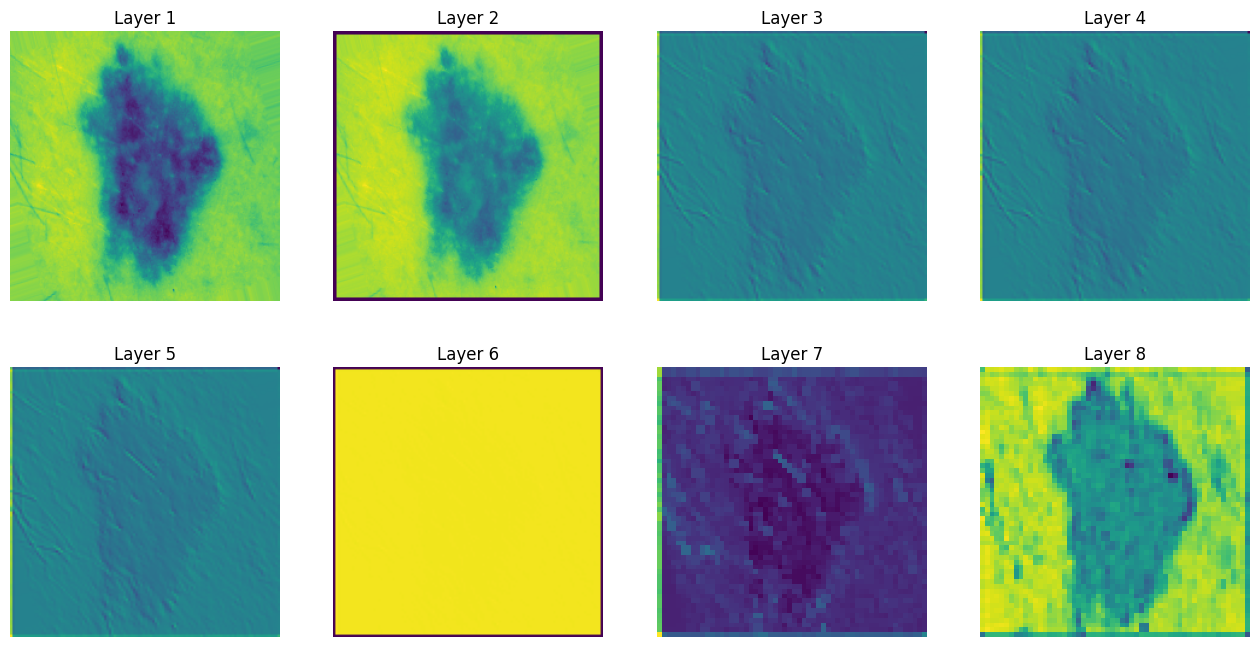

In [ ]:
# Select Layers for Visualization
layer_outputs = [layer.output for layer in base_model.layers[:8]]
activation_model = Model(inputs=base_model.input, outputs=layer_outputs)

# Load a Sample Image (Assuming train_generator is already defined)
sample_image, _ = next(train_generator)
sample_image = sample_image[0:1]  # Use one image

# Get Feature Maps
feature_maps = activation_model.predict(sample_image)

# Plot Feature Maps for First Few Layers
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for i in range(8):
    axes[i].imshow(feature_maps[i][0, :, :, 0], cmap='viridis')
    axes[i].set_title(f'Layer {i+1}')
    axes[i].axis('off')

plt.show()


In [ ]:
# Freeze Initial Layers (Retain Pretrained Knowledge)
for layer in base_model.layers[:140]:  # Adjust fine-tuning layers as needed
    layer.trainable = False

# Add Custom Fully Connected Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)  # Prevent Overfitting
output_layer = Dense(train_generator.num_classes, activation='softmax')(x)

# Create Final Model
model = Model(inputs=base_model.input, outputs=output_layer)

# Summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,114,055 (91.99 MB)

 Trainable params: 15,504,391 (59.14 MB)

 Non-trainable params: 8,609,664 (32.84 MB)

In [ ]:
from tensorflow.keras.optimizers import Adam

# Set number of epochs
EPOCHS = 20

# Define Optimizer
optimizer = Adam(learning_rate=0.0001)

# Compile Model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
)


Epoch 1/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 201s 721ms/step - accuracy: 0.7292 - loss: 0.7541 - val_accuracy: 0.5405 - val_loss: 2.1553
Epoch 2/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 171s 679ms/step - accuracy: 0.7225 - loss: 0.7568 - val_accuracy: 0.6000 - val_loss: 1.2194
Epoch 3/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 170s 680ms/step - accuracy: 0.7255 - loss: 0.7638 - val_accuracy: 0.7050 - val_loss: 2.2910
Epoch 4/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 176s 702ms/step - accuracy: 0.7265 - loss: 0.7469 - val_accuracy: 0.1115 - val_loss: 4.0857
Epoch 5/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 170s 677ms/step - accuracy: 0.7335 - loss: 0.7475 - val_accuracy: 0.6700 - val_loss: 9.2883


In [ ]:
# Evaluate Model
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc:.2f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 532ms/step - accuracy: 0.6790 - loss: 9.1638
Validation Accuracy: 0.67


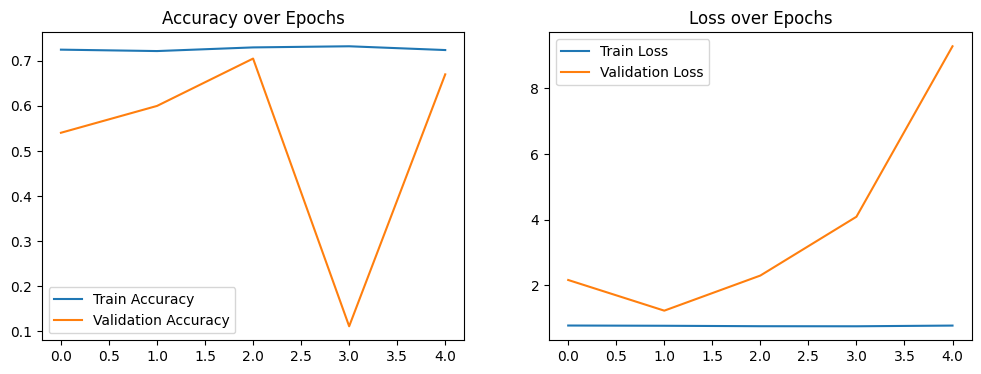

In [ ]:
# Plot Training Performance
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()

# MobileNet :

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define again
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2
)

# Recreate generators
train_generator = datagen.flow_from_directory(
    directory=organized_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    directory=organized_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)


Found 8015 images belonging to 7 classes.
Found 2000 images belonging to 7 classes.


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
mobilenet_base.trainable = False  # Freeze base


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
x = mobilenet_base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

mobilenet_model = Model(inputs=mobilenet_base.input, outputs=output)


In [ ]:
mobilenet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
mobilenet_history = mobilenet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 207s 777ms/step - accuracy: 0.5185 - loss: 1.6185 - val_accuracy: 0.6810 - val_loss: 0.9254
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 160s 638ms/step - accuracy: 0.6724 - loss: 1.0240 - val_accuracy: 0.6945 - val_loss: 0.8549
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 162s 644ms/step - accuracy: 0.6879 - loss: 0.9355 - val_accuracy: 0.6990 - val_loss: 0.8254
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 161s 642ms/step - accuracy: 0.6928 - loss: 0.8900 - val_accuracy: 0.7015 - val_loss: 0.8037
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 162s 645ms/step - accuracy: 0.6981 - loss: 0.8749 - val_accuracy: 0.7085 - val_loss: 0.7878
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 167s 668ms/step - accuracy: 0.7113 - loss: 0.8441 - val_accuracy: 0.7130 - val_loss: 0.7707
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 161s 641ms/step - accuracy: 0.7026 - loss: 0.8459 - val_accuracy: 0.7230 - val_loss: 0.7594
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 160s 638ms/step - accuracy: 0.7155 -

In [ ]:
#The Architecture Summary
mobilenet_model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,752,599 (10.50 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 329,744 (1.26 MB)

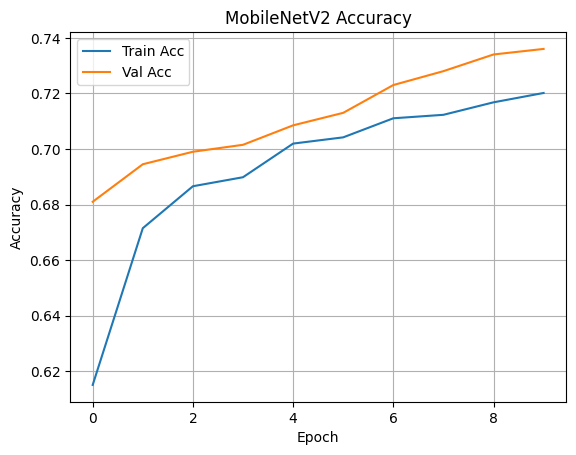

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, title):
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history(mobilenet_history, "MobileNetV2 Accuracy")


Convert Into Data from multiclass into Binary


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam


In [ ]:
# Path to the metadata CSV file
metadata_path = "/content/HAM10000/HAM10000_metadata.csv"
df = pd.read_csv(metadata_path)

# Check columns and class distribution
print(df['dx'].value_counts())


dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [ ]:
# Define classes
benign_classes = ['nv', 'bkl', 'df']
malignant_classes = ['mel', 'bcc', 'vasc', 'akiec']

# Create binary label
df['binary_label'] = df['dx'].apply(lambda x: 'benign' if x in benign_classes else 'malignant')


In [ ]:
# Step 4: Split Dataset
train_df, test_val_df = train_test_split(df, test_size=0.3, stratify=df['binary_label'], random_state=42)
val_df, test_df = train_test_split(test_val_df, test_size=0.5, stratify=test_val_df['binary_label'], random_state=42)

print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))


Train size: 7010
Validation size: 1502
Test size: 1503


In [ ]:
#Step 5: Organize Image Folders for Binary Classification
IMG_DIR = "/content/HAM10000/images"  # path to all images
BINARY_BASE = "/content/skin-cancer-binary"

for split_name, split_df in zip(["train", "val", "test"], [train_df, val_df, test_df]):
    for label in ['benign', 'malignant']:
        os.makedirs(os.path.join(BINARY_BASE, split_name, label), exist_ok=True)

    for _, row in split_df.iterrows():
        label = 'benign' if row['dx'] in benign_classes else 'malignant'
        img_name = row['image_id'] + ".jpg"
        src = os.path.join(IMG_DIR, img_name)
        dst = os.path.join(BINARY_BASE, split_name, label, img_name)
        if os.path.exists(src):
            shutil.copy(src, dst)


In [ ]:
import os
print("Sample image:", os.listdir(IMG_DIR)[:5])


Sample image: ['HAM10000_images_part_1', 'HAM10000_metadata.csv', 'HAM10000_images_part_2', 'hmnist_28_28_RGB.csv', 'hmnist_8_8_RGB.csv']


In [ ]:
src = os.path.join(IMG_DIR, img_name)


In [ ]:
import os
print(os.listdir("/content"))


['.config', 'skin-cancer-mnist-ham10000.zip', 'skin-cancer-mnist-ham10000', 'HAM10000', 'skin-cancer-binary', 'sample_data']


In [ ]:
IMG_DIR1 = "/content/skin-cancer-mnist-ham10000/ham10000_images_part_1"
IMG_DIR2 = "/content/skin-cancer-mnist-ham10000/ham10000_images_part_2"

IMG_PATHS = {img: os.path.join(IMG_DIR1, img) for img in os.listdir(IMG_DIR1)}
IMG_PATHS.update({img: os.path.join(IMG_DIR2, img) for img in os.listdir(IMG_DIR2)})


In [ ]:
import glob
len(glob.glob("/content/**/*.jpg", recursive=True))


40061

In [ ]:
import os
import shutil

# Merge both image folders if they exist
IMG_DIR1 = "/content/skin-cancer-mnist-ham10000/ham10000_images_part_1"
IMG_DIR2 = "/content/skin-cancer-mnist-ham10000/ham10000_images_part_2"

IMG_PATHS = {}
for img_dir in [IMG_DIR1, IMG_DIR2]:
    if os.path.exists(img_dir):
        IMG_PATHS.update({img: os.path.join(img_dir, img) for img in os.listdir(img_dir)})

BINARY_BASE = "/content/skin-cancer-binary"

for split_name, split_df in zip(["train", "val", "test"], [train_df, val_df, test_df]):
    for label in ['benign', 'malignant']:
        os.makedirs(os.path.join(BINARY_BASE, split_name, label), exist_ok=True)

    for _, row in split_df.iterrows():
        label = 'benign' if row['dx'] in benign_classes else 'malignant'
        img_name = row['image_id'] + ".jpg"
        src = IMG_PATHS.get(img_name)
        dst = os.path.join(BINARY_BASE, split_name, label, img_name)

        if src and os.path.exists(src):  # Copy only if the image exists
            shutil.copy(src, dst)
        else:
            print(f"Missing image: {img_name}")


In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
BINARY_BASE = "/content/skin-cancer-binary"  # Ensure this is where your images are copied

# Create the image data generator
datagen = ImageDataGenerator(rescale=1./255)

# Train generator
train_generator = datagen.flow_from_directory(
    os.path.join(BINARY_BASE, "train"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Validation generator
val_generator = datagen.flow_from_directory(
    os.path.join(BINARY_BASE, "val"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Test generator
test_generator = datagen.flow_from_directory(
    os.path.join(BINARY_BASE, "test"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 7010 images belonging to 2 classes.
Found 1502 images belonging to 2 classes.
Found 1503 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    '/content/skin-cancer-binary/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')

val_generator = datagen.flow_from_directory(
    '/content/skin-cancer-binary/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')

test_generator = datagen.flow_from_directory(
    '/content/skin-cancer-binary/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')


Found 7010 images belonging to 2 classes.
Found 1502 images belonging to 2 classes.
Found 1503 images belonging to 2 classes.


In [ ]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 95s 403ms/step - accuracy: 0.7782 - loss: 0.5742 - val_accuracy: 0.7923 - val_loss: 0.4476
Epoch 2/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 70s 317ms/step - accuracy: 0.7825 - loss: 0.4743 - val_accuracy: 0.7610 - val_loss: 0.4527
Epoch 3/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 60s 273ms/step - accuracy: 0.7847 - loss: 0.4670 - val_accuracy: 0.7903 - val_loss: 0.4480
Epoch 4/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 60s 271ms/step - accuracy: 0.7889 - loss: 0.4546 - val_accuracy: 0.7916 - val_loss: 0.4433
Epoch 5/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 62s 280ms/step - accuracy: 0.7907 - loss: 0.4312 - val_accuracy: 0.7943 - val_loss: 0.4539
Epoch 6/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 60s 273ms/step - accuracy: 0.7912 - loss: 0.4544 - val_accuracy: 0.7903 - val_loss: 0.4268
Epoch 7/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 61s 277ms/step - accuracy: 0.7975 - loss: 0.4128 - val_accuracy: 0.7949 - val_loss: 0.4166
Epoch 8/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 60s 273ms/step - accuracy: 0.8109 - loss: 0

In [ ]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 341ms/step - accuracy: 0.8067 - loss: 0.4040
Test Accuracy: 79.91%


In [ ]:
import pandas as pd

# Define comparison results
comparison_results = {
    "Model": ["ResNet50", "MobileNetV2"],
    "Resarch Paper Accuracy": [0.91, 0.96],
    "My Model Accuracy": [0.7335, 0.7218],
}

# Convert to DataFrame
df_comparison = pd.DataFrame(comparison_results)

# Print the table
print("\n📊 Research Paper vs. My Results:")
print(df_comparison)


📊 Research Paper vs. My Results:
         Model  Resarch Paper Accuracy  My Model Accuracy
0     ResNet50                    0.91             0.7335
1  MobileNetV2                    0.96             0.7218


**Declaration**

I, Vaishnavi Kedar, confirm that the work submitted in this assignment is my own and has been completed following academic integrity guidelines. The code is uploaded on my GitHub repository account, and the repository link is provided below:

GitHub Repository Link:
    https://github.com/vaishnavi-kedar/demo1/blob/548d952b27ce1133cb4d5470bf4d6ceacf525c0b/DeepLearningLabAssignment_5.ipynb


Signature: Vaishnavi Kedar